# Quantum Time Series Analysis: Analysis
Compatible with Qiskit 1.02+

### Authors
- **Jacob Cybulski**, jacob.cybulski[at]deakin.edu.au<br/>
    School of IT, SEBE, Deakin University, Melbourne, Vic, Australia

### Date
- October 2022: Prepared for Workshop on Quantum Machine Learning, 13 October 2022, organised in collaboration with QWorld, QPoland, QIndia and Quantum AI Foundation. In association with IEEE Conference Trends in Quantum Computing and Emerging Business Technologies - TQCEBT 2022
- May 2024: Compatibility upgrade to Qiskit 1.02 

### Aims
> *This script aims to analyse log data.*

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../../..')
sys.path

['/home/jacob/miniconda3/envs/qiskit100/lib/python311.zip',
 '/home/jacob/miniconda3/envs/qiskit100/lib/python3.11',
 '/home/jacob/miniconda3/envs/qiskit100/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit100/lib/python3.11/site-packages',
 '.',
 '..',
 '../../..']

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import math
from IPython.display import clear_output
from qiskit_algorithms.utils import algorithm_globals

from utils.Target import *
from utils.Window import *
from utils.Callback import *
from utils.TS import *
from utils.Charts import *
from utils.Integrate import *
from utils.Circuits import *
from utils.Angles import *
from utils.Files import *
from utils.Cost import *
from utils.Metrics import *

from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

## Load dataset hyper-parameters

In [4]:
### Listing control
debug = True
seed = 2022

### Software version
MAJOR = 8
MINOR = 10

### Constants
LOG_NAME = 'log_1'
CASE_NAME = 'serial'
DATA_NAME = '2_sins'
DATA_PATH = f'{LOG_NAME}/data'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Show constants
(LOG_NAME, CASE_NAME, DATA_NAME,DATA_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, FIGURES_PATH)

('log_1',
 'serial',
 '2_sins',
 'log_1/data',
 'log_1/training',
 'log_1/params',
 'log_1/analysis',
 'log_1/figures')

In [5]:
### Load repository info
data_info_path = f'{DATA_PATH}/2_sins_t50_v20_z0.0_w0_s0_h0_info.json'
data_info = read_json_file(data_info_path)
data_info

{'data_name': '2_sins',
 'major_version': 8,
 'minor_version': 10,
 'data_train': 50,
 'data_valid': 20,
 'data_noise': 0.0,
 'wind_size': 0,
 'wind_step': 0,
 'wind_horizon': 0,
 'seed': 2022}

In [6]:
### Start random process
seed = data_info['seed']
algorithm_globals.random_seed = data_info['seed']

# Software version
major_version = data_info['major_version']
minor_version = data_info['minor_version']

### Data settings
samples_train = data_info['data_train']
samples_valid = data_info['data_valid']
samples = samples_train+samples_valid
train_pc = samples_train / samples
noise = data_info['data_noise']

### Define the time series parameters
#   wind_size: sliding window size (which may be the same as number of qubits)
#   horizon:   the number of time events to look ahead (to forecast)
wind_size = data_info['wind_size']
wind_step = data_info['wind_step']
horizon = data_info['wind_horizon']

In [7]:
### All created files have the following codes:
#   t: training sample size
#   v: validation sample size
#   z: level of noise injected
#   w: window size
#   s: window step size
#   h: horizon size
DATA_PREF = f'{DATA_NAME}_t{samples_train}_v{samples_valid}_z{noise}_w{wind_size}_s{wind_step}_h{horizon}'
DATA_PREF

'2_sins_t50_v20_z0.0_w0_s0_h0'

## Load the necessary files

In [8]:
### Define file names

x_all_fpath = f'{DATA_PATH}/{DATA_PREF}_x_all.arr'
y_all_fpath = f'{DATA_PATH}/{DATA_PREF}_y_all.arr'

x_train_fpath = f'{DATA_PATH}/{DATA_PREF}_x_train.arr'
y_train_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train.arr'
x_valid_fpath = f'{DATA_PATH}/{DATA_PREF}_x_valid.arr'
y_valid_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid.arr'

data_info_fpath = f'{DATA_PATH}/{DATA_PREF}_info.json'
data_info_fpath

'log_1/data/2_sins_t50_v20_z0.0_w0_s0_h0_info.json'

In [9]:
### Load the necessary data and reshape as necessary

X_all = read_ts_file(x_all_fpath).reshape(samples, 1)
y_all = read_ts_file(y_all_fpath)

X_train = read_ts_file(x_train_fpath).reshape(samples_train, 1)
y_train = read_ts_file(y_train_fpath)

X_valid = read_ts_file(x_valid_fpath).reshape(samples_valid, 1)
y_valid = read_ts_file(y_valid_fpath)

## Plot data files

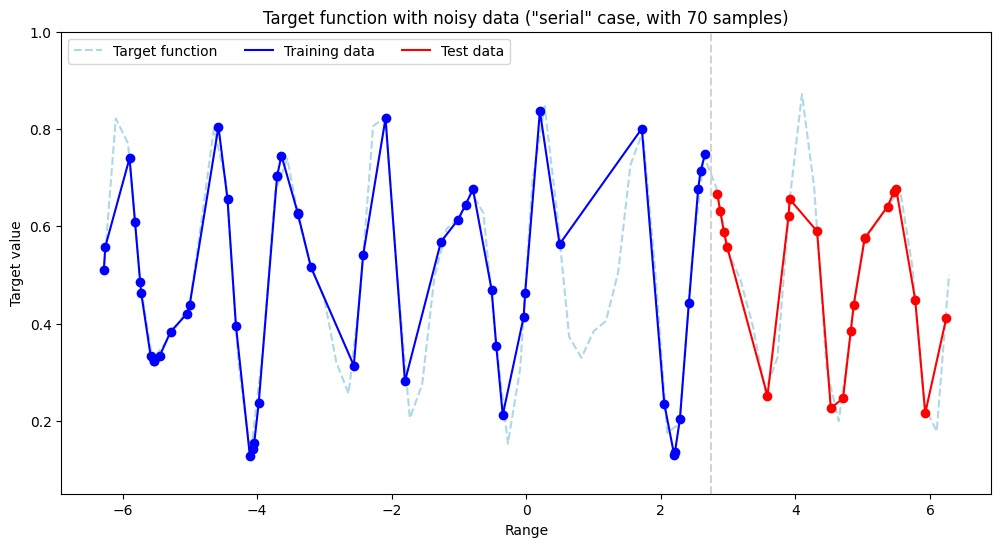

In [12]:
### Plot data
plot_train_and_test_data(
    X_all, y_all, X_train, y_train, X_valid, y_valid, ylim=(0.05, 1),
    colors=['lightblue', 'blue', 'red', 'blue', 'red'], linestyles=['dashed', 'solid', 'solid'],
    title=f'Target function with noisy data ("{CASE_NAME}" case, with {samples} samples)',
    save_plot=f'{FIGURES_PATH}/qtsa_{DATA_NAME}_{CASE_NAME}_fun_and_noise.eps')

## Analysis of a Quantum Autoencoder

In [17]:
### Libraries used in QAE development

import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [18]:
from qiskit_aer.backends import AerSimulator
from qiskit import Aer, execute
# noise_model = NoiseModel.from_backend(backend)
backend = AerSimulator(method='statevector')
backend.set_option('device', 'CPU')
backend.set_option('seed_simulator', seed)
backend.set_option('cuStateVec_enable', True)

### Defining structures of training and testing models and their components
*Note that the trainnig model will be used further, however, the testting model is used only as a reference for its structural properties. The actual testing models will be generated dynamically.*

QAE characteristics: 

	training windows=146
	validation windows=24
	inputs=8
	weights=108
	trash layer=1
	latent layer=7
	training qubits=9
	testing qubits=9
	reps=2
	added_width=1
	ent=sca
	rot_block=['rx', 'ry']
	noise=0.03
	noise repeats=1

	shuffle interv=0
	log interv=10
	cost type=obj_fun_mae
	cost yscale=linear
	samples=146
	device=CPU
	epochs=1000
	shots=100000


Model:



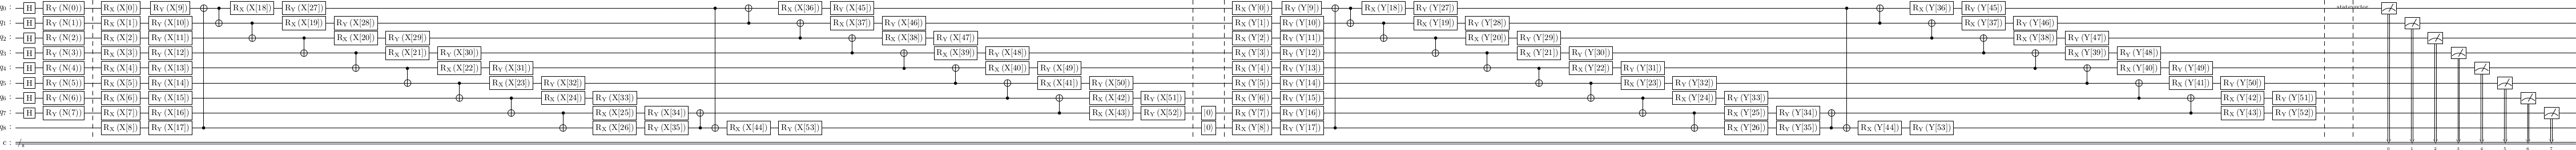

In [20]:
### Selects device
device='CPU'

### Models structures

test_qae, in_params, enc_params, dec_params, all_weight_params = \
    qae_xyz_xdf(num_latent, num_trash, reps=reps, ent=ent, added_width=added_width,
                rotation_blocks=['rx', 'ry'], invert_dec=False,
                add_statevector=True, in_seq_label='N', in_seq_name='Noisy Input')     

test_qae = test_qae.decompose()

### Report model details
print(f'QAE characteristics: \n\n'+
      f'\ttraining windows={len(y_train_enc)}\n'+
      f'\tvalidation windows={len(y_valid_enc)}\n'+
      f'\tinputs={len(in_params)}\n'+
      f'\tweights={len(all_weight_params)}\n'+
      f'\ttrash layer={num_trash}\n'+
      f'\tlatent layer={num_latent}\n'+
      f'\ttraining qubits={len(test_qae.qubits)}\n'+
      f'\ttesting qubits={len(test_qae.qubits)}\n'+
      f'\treps={reps}\n'+
      f'\tadded_width={added_width}\n'+
      f'\tent={ent}\n'+
      f'\trot_block={rot_block}\n'+
      f'\tnoise={noise}\n'+
      f'\tnoise repeats={noise_reps}\n'+
      f'\n'+
      f'\tshuffle interv={shuffle_interv}\n'+
      f'\tlog interv={log_interv}\n'+
      f'\tcost type={cost_type}\n'+
      f'\tcost yscale={cost_yscale}\n'+
      f'\tsamples={y_train_enc.shape[0]}\n'+
      f'\tdevice={device}\n'+
      f'\tepochs={epochs}\n'+
      f'\tshots={shots}\n'+
      ''
     )

print('\nModel:\n')
display(test_qae.draw("latex", style="iqp", scale=0.7))
print('')

## Utilities

In [21]:
### Testing the model (get the result for a single window)
#   Note: the slower version measuring individual qubits was removed
def test_with_noise_fast(in_wind, opt_params, backend, nlat=5, ntr=3, reps=2, added_width=1, 
                         ent='sca', rot_block=['ry'], shots=10000):

    out_qc, _, _, _, _ = \
        qae_xyz_xdf(nlat, ntr, reps=reps, ent=ent, rotation_blocks=rot_block, invert_dec=False, add_statevector=True, added_width=added_width)
    param_values = np.concatenate((in_wind, opt_params))
    out_qc = out_qc.assign_parameters(param_values)
    out_qc = out_qc.decompose().decompose()
    out_wind, probs = multi_qubit_angle_meas(out_qc, backend, shots=shots)

    return out_wind[:-added_width]

### Scoring the model
def score_model(score_fun, inp_ts, ref_ts, opt_params, backend, 
                nlat=5, ntr=3, reps=2, ent='sca', rot_block=['ry'], shots=10000, messg=None, added_width=1):
    if messg is not None: print(f'{messg}:\t', end=' ')
    score = 0
    out_ts = []
    for idx in range(inp_ts.shape[0]):
        in_wind = inp_ts[idx]
        out_wind = test_with_noise_fast(in_wind, opt_params, backend, 
                nlat=nlat, ntr=ntr, reps=reps, ent=ent, rot_block=rot_block, shots=shots, added_width=added_width)
        out_ts.append(out_wind)
        if messg is not None: print(f'{idx}', end=' ')
    if messg is not None: print()
    score = score_fun(np.array(out_ts), np.array(ref_ts))
    return score

In [22]:
### Test test_with_noise_fast
noisy_in = [-0.00377532, -0.07484839, -0.05185779, -0.11264725,  
             0.05508961,  0.08875359, -0.1630023,  -0.02983954]
pure_out = test_with_noise_fast(noisy_in, optimum_parameters, backend, 
                nlat=num_latent, ntr=num_trash, reps=reps, ent=ent, rot_block=rot_block, shots=1000, added_width=added_width)
pure_out = [round(x, 5) for x in pure_out]
pure_out
# slow, shots=1000000: [-0.00131, -0.08009, -0.0411, -0.11325, 0.04607, 0.09186, -0.16662, 0.00547]
# slow, shots=100000:  [-0.00866, -0.08645, -0.04704, -0.12051, 0.03899, 0.08494, -0.17517, -0.00214]
# slow, shots=10000:   [-0.0248, -0.11666, -0.04962, -0.024, 0.03461, 0.04281, -0.1757, -0.0026]
# slow, shots=1000:    [-0.016, -0.11224, -0.04001, -0.016, 0.04001, 0.05403, -0.16474, 0.002]
# slow, shots=100:     [0.04001, -0.06004, 0.02, 0.04001, 0.16069, 0.18099, -0.12029, 0.06004]
# slow, shots=10:      [-0.20136, -0.20136, -0.20136, -0.20136, -0.20136, 0.0, -0.20136, -0.20136]
# slow, shots=1:       [1.5708, 1.5708, 1.5708, 1.5708, 1.5708, 1.5708, 1.5708, 1.5708]
#
# fast, shots=1:       [-0.00179, -0.08035, -0.04135, -0.11294, 0.04578, 0.09104, -0.1668, 0.00501]
# fast, shots=1000:    [-0.00195, -0.08037, -0.04137, -0.11298, 0.04574, 0.09123, -0.16688, 0.00487]
# fast, shots=1000000: [-0.00195, -0.08037, -0.04137, -0.11298, 0.04574, 0.09123, -0.16688, 0.00487]

[0.01715, 0.01015, 0.0149, -0.00721, 0.00479, 0.00953, 0.03078, 0.06496]

In [23]:
### Check sizes of parameter file
print(f'History length: {history_parameters.shape[0]}')
print(f'Parameters number: {history_parameters.shape[1]}')

History length: 100
Parameters number: 108


In [25]:
### Test model scoring
curr_params_no = 33
loss_interv = 2
curr_params = history_parameters[curr_params_no*loss_interv]
print(f'\nParameters set #{curr_params_no*loss_interv}:\n')

sel_noise_set = 0
shots_no = shots
in_ts = y_train_noisy_enc[sel_noise_set][38:48]
ref_ts = y_train_enc[38:48]

r2_score =    score_model(lambda x, y: r2_flat_tswin(x, y, trim_left=0, trim_right=0), 
                          in_ts, ref_ts, curr_params, backend, messg='R2 scores calculated',
                          nlat=num_latent, ntr=num_trash, reps=reps, ent=ent, shots=shots_no, 
                          rot_block=rot_block, added_width=added_width)
rms_score =   score_model(lambda x, y: rms_flat_tswin(x, y, trim_left=0, trim_right=0), 
                          in_ts, ref_ts, curr_params, backend, messg='RMS scores calculated', 
                          nlat=num_latent, ntr=num_trash, reps=reps, ent=ent, shots=shots_no, 
                          rot_block=rot_block, added_width=added_width)
mae_score =   score_model(lambda x, y: mae_flat_tswin(x, y, trim_left=0, trim_right=0), 
                          in_ts, ref_ts, curr_params, backend, messg='MAE scores calculated', 
                          nlat=num_latent, ntr=num_trash, reps=reps, ent=ent, shots=shots_no, 
                          rot_block=rot_block, added_width=added_width)
print(f'\nTest scores for parameters set #{curr_params_no*loss_interv} + shots={shots_no}: '+
      f'R2={np.round(r2_score, 4)}, MAE={np.round(mae_score, 4)}, RMS={np.round(rms_score, 4)}\n')

# Test scores #20 for shots=1000: R2=-0.2902, MAE=0.2473, RMS=0.318
# Test scores #20 for shots=10000: R2=-0.2845, MAE=0.2428, RMS=0.3134

# Test scores #200 for shots=1000: R2=0.1828, MAE=0.1435, RMS=0.1822
# Test scores #200 for shots=10000: R2=0.2328, MAE=0.14, RMS=0.1762

# Test scores #490 for shots=1000: R2=0.6239, MAE=0.0727, RMS=0.1012
# Test scores #490 for shots=10000: R2=0.6152, MAE=0.0739, RMS=0.1026


Parameters set #66:

R2 scores calculated:	 0 1 2 3 4 5 6 7 8 9 
RMS scores calculated:	 0 1 2 3 4 5 6 7 8 9 
MAE scores calculated:	 0 1 2 3 4 5 6 7 8 9 

Test scores for parameters set #66 + shots=100000: R2=-116.1747, MAE=0.2067, RMS=0.2858



## Performance analysis

### Recorded cost function over training

In [26]:
create_folder_if_needed(f'{FIGURES_PATH}/{TRAIN_PREF}_{epochs}')

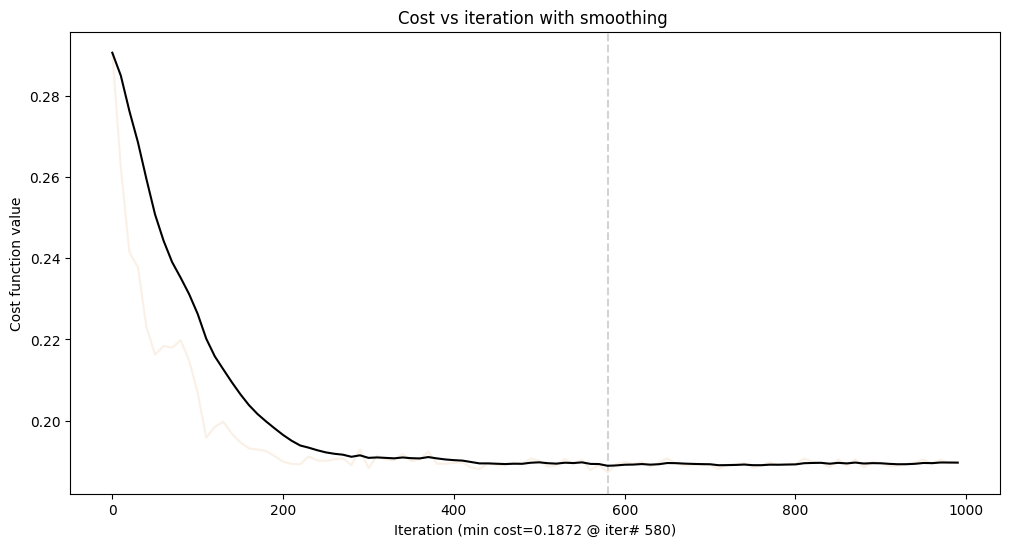


History length: 100, log interval: 10, shots: 100000



In [27]:
cost_plot(history, log_interv=log_interv, rcParams=(12, 6), smooth_weight=0.8, backplot=True, 
          save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_{epochs}/hist_full.eps')
print(f'\nHistory length: {len(history)}, log interval: {log_interv}, shots: {shots}\n')

### Downsized cost function (only if needed)

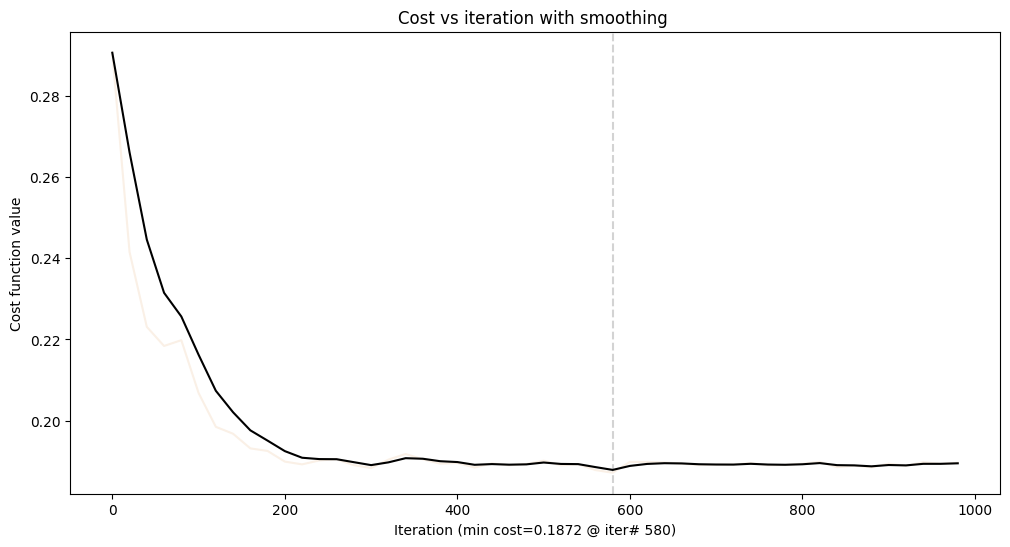

Length of loss scores: 50



In [28]:
### Find a subset of losses
loss_interv = 2 # Reduction step used when history is too large
sel_subset = len(history) // loss_interv
loss_scores = [history[idx*loss_interv] for idx in range(sel_subset)]
cost_plot(loss_scores, log_interv=loss_interv*log_interv, rcParams=(12, 6), smooth_weight=0.5, backplot=True, 
          save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_{epochs}/hist_reduced.eps')
print(f'Length of loss scores: {len(loss_scores)}\n')

### Calculate and report performance stats

In [29]:
import time
import datetime

In [30]:
### Select nosy curve
sel_noise_idx = 0
sel_shots = 1

### Initialise all score curves
r2_train_scores = [];  r2_valid_scores = []
rms_train_scores = []; rms_valid_scores = []
mae_train_scores = []; mae_valid_scores = []

### Start time
start = time.time()

### Collect scores across history
print(f'Score iterations:\t', end=' ')
for params_no in range(len(loss_scores)):
    
    curr_params = history_parameters[params_no*loss_interv]
    
    r2_train_scores.append(score_model(lambda x, y: r2_flat_tswin(x, y, trim_left=0, trim_right=0), 
                           y_train_noisy_enc[sel_noise_idx], y_train_enc, curr_params, backend, 
                           nlat=num_latent, ntr=num_trash, reps=reps, ent=ent, shots=sel_shots, 
                           rot_block=rot_block, added_width=added_width))
    rms_train_scores.append(score_model(lambda x, y: rms_flat_tswin(x, y, trim_left=0, trim_right=0), 
                            y_train_noisy_enc[sel_noise_idx], y_train_enc, curr_params, backend, 
                            nlat=num_latent, ntr=num_trash, reps=reps, ent=ent, shots=sel_shots, 
                            rot_block=rot_block, added_width=added_width))
    mae_train_scores.append(score_model(lambda x, y: mae_flat_tswin(x, y, trim_left=0, trim_right=0), 
                            y_train_noisy_enc[sel_noise_idx], y_train_enc, curr_params, backend, 
                            nlat=num_latent, ntr=num_trash, reps=reps, ent=ent, shots=sel_shots, 
                            rot_block=rot_block, added_width=added_width))
    
    r2_valid_scores.append(score_model(lambda x, y: r2_flat_tswin(x, y, trim_left=0, trim_right=0), 
                           y_valid_noisy_enc[sel_noise_idx], y_valid_enc, curr_params, backend, 
                           nlat=num_latent, ntr=num_trash, reps=reps, ent=ent, shots=sel_shots, 
                           rot_block=rot_block, added_width=added_width))
    rms_valid_scores.append(score_model(lambda x, y: rms_flat_tswin(x, y, trim_left=0, trim_right=0), 
                            y_valid_noisy_enc[sel_noise_idx], y_valid_enc, curr_params, backend, 
                            nlat=num_latent, ntr=num_trash, reps=reps, ent=ent, shots=sel_shots, 
                            rot_block=rot_block, added_width=added_width))
    mae_valid_scores.append(score_model(lambda x, y: mae_flat_tswin(x, y, trim_left=0, trim_right=0), 
                            y_valid_noisy_enc[sel_noise_idx], y_valid_enc, curr_params, backend, 
                            nlat=num_latent, ntr=num_trash, reps=reps, ent=ent, shots=sel_shots, 
                            rot_block=rot_block, added_width=added_width))
    
    print(f'{params_no}', end=' ')

print('End\n')

### Stop time and report
elapsed = time.time() - start
time_str = str(datetime.timedelta(seconds=int(elapsed)))
print(f'Time taken: {time_str}, elapsed: {elapsed:0.2f} sec')

### Collect statistics
r2_train_x_of_max = np.argmax(r2_train_scores);   r2_train_max = r2_train_scores[r2_train_x_of_max]
mae_train_x_of_min = np.argmin(mae_train_scores); mae_train_min = mae_train_scores[mae_train_x_of_min]
rms_train_x_of_min = np.argmin(rms_train_scores); rms_train_min = rms_train_scores[rms_train_x_of_min]

r2_valid_x_of_max = np.argmax(r2_valid_scores);   r2_valid_max = r2_valid_scores[r2_valid_x_of_max]
mae_valid_x_of_min = np.argmin(mae_valid_scores); mae_valid_min = mae_valid_scores[mae_valid_x_of_min]
rms_valid_x_of_min = np.argmin(rms_valid_scores); rms_valid_min = rms_valid_scores[rms_valid_x_of_min]

### Select optimum parameters, as per MAE scores
opt_train_params = history_parameters[mae_train_x_of_min*loss_interv]
opt_valid_params = history_parameters[mae_valid_x_of_min*loss_interv]

Score iterations:	 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 End

Time taken: 0:26:03, elapsed: 1563.75 sec


In [42]:
print(f'\nQiskit model performance as per scores collected at intervals of {log_interv} iterations, over {epochs} epochs')
print(f'\n{"Performance":<10}\tTraining\tValidation\n')

print(f'{"R2":<10}\t{np.round(r2_train_max, 3):<5} @ {r2_train_x_of_max*log_interv*loss_interv}'+
      f'\t{np.round(r2_valid_max, 3):<5} @ {r2_valid_x_of_max*log_interv*loss_interv}')

print(f'{"RMS":<10}\t{np.round(rms_train_min, 3):<5} @ {rms_train_x_of_min*log_interv*loss_interv}'+
      f'\t{np.round(rms_valid_min, 3):<5} @ {rms_valid_x_of_min*log_interv*loss_interv}')

print(f'{"MAE (optimum)":<10}\t{np.round(mae_train_min, 3):<5} @ {mae_train_x_of_min*log_interv*loss_interv}'+
      f'\t{np.round(mae_valid_min, 3):<5} @ {mae_valid_x_of_min*log_interv*loss_interv}')

print()


Qiskit model performance as per scores collected at intervals of 10 iterations, over 1000 epochs

Performance	Training	Validation

R2        	-1.297 @ 0	-1.047 @ 0
RMS       	0.291 @ 380	0.244 @ 380
MAE (optimum)	0.19  @ 380	0.177 @ 380



### Define location and save performance data

In [43]:
train_inorg_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}/winds_torg.json'
train_inmeas_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}/winds_tinm.json'
train_outrec_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}/winds_tout.json'
valid_inorg_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}/winds_vorg.json'
valid_inmeas_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}/winds_vinm.json'
valid_outrec_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}/winds_vout.json'

info_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}/info.json'
stats_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}/stats.json'
scores_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}/scores.json'
loss_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}/hist_loss.arr'
tr2_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}/hist_tr2.arr'
vr2_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}/hist_vr2.arr'
tmae_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}/hist_tmae.arr'
vmae_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}/hist_vmae.arr'
trms_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}/hist_trms.arr'
vrms_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}/hist_vrms.arr'
tmae_fpath

'beer_xtest/analysis/2step_xy_n200_w8_ws2_z0.03_zr1_reps2_aw1_sca_lat7_1000/hist_tmae.arr'

In [44]:
### Save all calculated data points
to_be_saved_perform = True

analysis_info = \
    {'case_name':CASE_NAME, 
     'major_version':major_version, 
     'minor_version':minor_version,
     'epochs':epochs,
     'log_interv':log_interv,
     'history_len':len(history),
     'score_len':len(loss_scores),
     'loss_interv':loss_interv,
     'sel_subset':sel_subset
    }

analysis_stats = \
    {'R2':[int(r2_train_x_of_max), r2_train_max, int(r2_valid_x_of_max), r2_valid_max],
     'RMS':[int(rms_train_x_of_min), rms_train_min, int(rms_valid_x_of_min), rms_valid_min],
     'MAE':[int(mae_train_x_of_min), mae_train_min, int(mae_valid_x_of_min), mae_valid_min]
    }

analysis_scores = \
    {'R2':[float(r2_train_max), int(r2_train_x_of_max*log_interv*loss_interv), float(r2_valid_max), int(r2_valid_x_of_max*log_interv*loss_interv)],
     'RMS':[float(rms_train_min), int(rms_train_x_of_min*log_interv*loss_interv), float(rms_valid_min), int(rms_valid_x_of_min*log_interv*loss_interv)],
     'MAE':[float(mae_train_min), int(mae_train_x_of_min*log_interv*loss_interv), float(mae_valid_min), int(mae_valid_x_of_min*log_interv*loss_interv)]
    }

if to_be_saved_perform:
    write_json_file(f'{info_fpath}', analysis_info)
    write_json_file(f'{stats_fpath}', analysis_stats)
    write_json_file(f'{scores_fpath}', analysis_scores)
    write_ts_file(f'{loss_fpath}', np.array(loss_scores))
    write_ts_file(f'{tr2_fpath}', np.array(r2_train_scores))
    write_ts_file(f'{vr2_fpath}', np.array(r2_valid_scores))
    write_ts_file(f'{tmae_fpath}', np.array(mae_train_scores))
    write_ts_file(f'{vmae_fpath}', np.array(mae_valid_scores))
    write_ts_file(f'{trms_fpath}', np.array(rms_train_scores))
    write_ts_file(f'{vrms_fpath}', np.array(rms_valid_scores))

    print(f'Saved all performance data in: "{ANALYSIS_PATH}/{TRAIN_PREF}_{epochs}" folder')
else:
    print(f'Performance data not saved') 

Saved all performance data in: "beer_xtest/analysis/2step_xy_n200_w8_ws2_z0.03_zr1_reps2_aw1_sca_lat7_1000" folder


### Produce performance charts

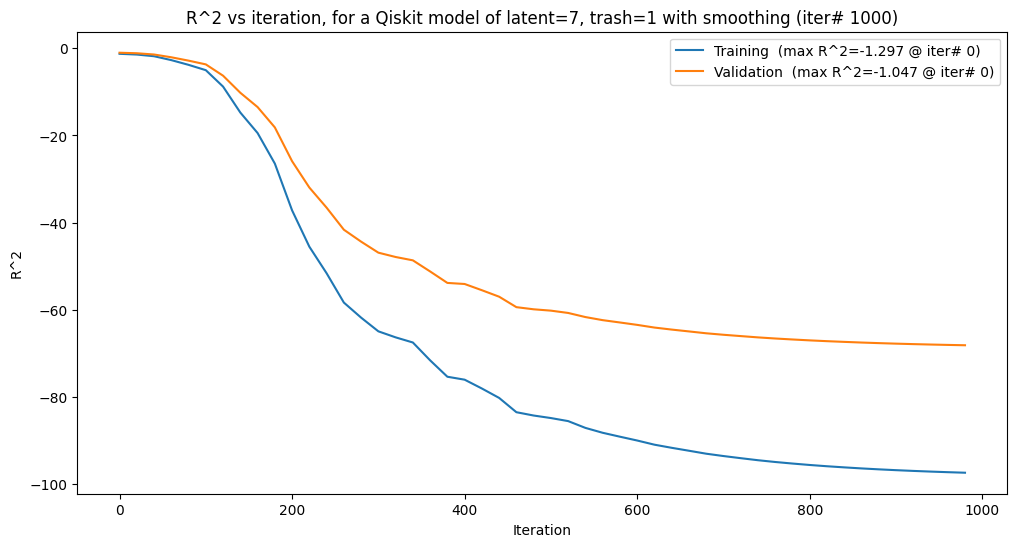

In [45]:
multi_perform_plot([r2_train_scores, r2_valid_scores], rcParams=(12, 6), yscale='linear', # yscale='log'
                  backplot=False, smooth_weight=0.9, save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_{epochs}/hist_r2.eps',
                  title=f'R^2 vs iteration, for a Qiskit model of latent={num_latent}, trash={num_trash}', meas_type='R^2', # ylim=(-2.6, 0.1),
                  labels=['Training', 'Validation'], meas_min=False, back_color='lightgray', log_interv=log_interv*loss_interv) 

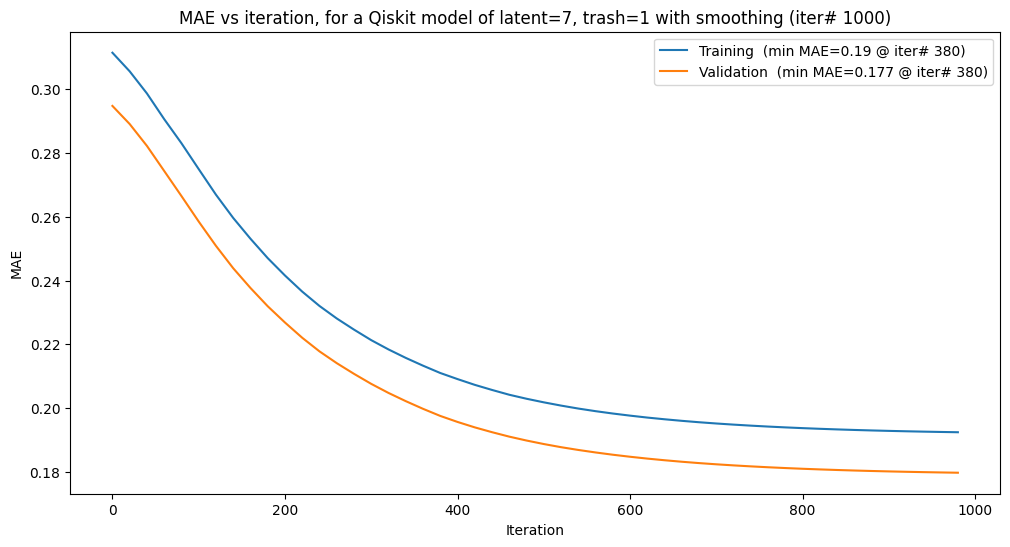

In [46]:
multi_perform_plot([mae_train_scores, mae_valid_scores], rcParams=(12, 6), yscale='linear', # yscale='log'
                  backplot=False, smooth_weight=0.9, save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_{epochs}/hist_mae.eps',
                  title=f'MAE vs iteration, for a Qiskit model of latent={num_latent}, trash={num_trash}', meas_type='MAE', # ylim=(-1, 1.4),
                  labels=['Training', 'Validation'], meas_min=True, back_color='lightgray', log_interv=log_interv*loss_interv)

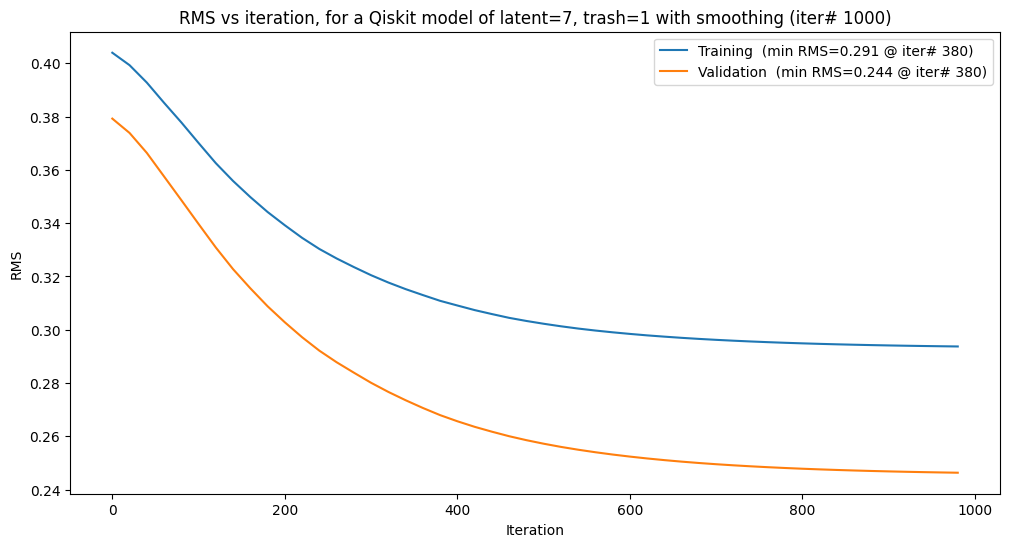

In [47]:
multi_perform_plot([rms_train_scores, rms_valid_scores], rcParams=(12, 6), yscale='linear', # yscale='log'
                  backplot=False, smooth_weight=0.9, save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_{epochs}/hist_rms.eps',
                  title=f'RMS vs iteration, for a Qiskit model of latent={num_latent}, trash={num_trash}', meas_type='RMS', # ylim=(0.11, 0.25),
                  labels=['Training', 'Validation'], meas_min=True, back_color='lightgray', log_interv=log_interv*loss_interv)

## Model analysis and testing
Note that all components of a test circuit will be built in the testing process

### QAE calculation and analysis of the selected TS windows

In [48]:
### Select a collection of windows to test

# sel_wind_train_set = random.sample(range(0, len(y_train_enc)), 20)
# sel_wind_valid_set = random.sample(range(0, len(y_valid_enc)), 20)
sel_wind_train_set = [*range(38, 58, 1)] # [*range(len(y_train_enc))]
sel_wind_valid_set = [*range(len(y_valid_enc))]

print(f'Selected {len(sel_wind_train_set)} training windows:\t{sel_wind_train_set}')
print(f'Selected {len(sel_wind_valid_set)} validation windows:\t{sel_wind_valid_set}')

Selected 20 training windows:	[38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
Selected 24 validation windows:	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [49]:
### Generation of QAE results for the selected windows

### Analyses a sample of windows, QAE(in) -> recons
### winds_pure: a list/array of TS windows
### sel_wind_set: a list of the selected windows indeces
### returns: dictionaries of a subset of original, measured, and reconstructured windows
###          the keys correspond to windows sequence position in a TS

def qae_analyse_sample(sel_wind_set, winds_pure, winds_noise, opt_params, wind_step=1, added_width=added_width):
    print(f'Processed windows: ', end=' ')

    in_org_set = {}
    in_meas_set = {}
    out_reconstr_set = {}

    for wind_idx in range(len(sel_wind_set)):
    
        sel_wind = sel_wind_set[wind_idx]
        #wind = winds_noise[sel_wind] # Use noisy window for manipulation

        ### Add pure window for reference
        in_org_set[sel_wind*wind_step] = list(winds_pure[sel_wind]) 
    
        ### The "measured" input is just a noisy window
        in_meas_set[sel_wind*wind_step] = list(winds_noise[sel_wind])

        ### Find the QAE input window state vector representation (as measured)
        out_meas = test_with_noise_fast(winds_noise[sel_wind], optimum_parameters, backend, rot_block=rot_block,
                nlat=num_latent, ntr=num_trash, reps=reps, ent=ent, shots=shots, added_width=added_width)
    
        ### Add window results
        out_reconstr_set[sel_wind*wind_step] = out_meas    
    
        print(f'{sel_wind}', end=' ')
    
    print('End\n')
    return in_org_set, in_meas_set, out_reconstr_set

In [50]:
### Analyse samples of training and validation data
sel_noise_set = 0
in_org_train_set, in_meas_train_set, out_reconstr_train_set = \
    qae_analyse_sample(sel_wind_train_set, y_train_enc, y_train_noisy_enc[sel_noise_set], 
                       optimum_parameters, wind_step=wind_step, added_width=added_width) # Noise vs Pure
in_org_valid_set, in_meas_valid_set, out_reconstr_valid_set = \
    qae_analyse_sample(sel_wind_valid_set, y_valid_enc, y_valid_noisy_enc[sel_noise_set], 
                       optimum_parameters, wind_step=wind_step, added_width=added_width) # Noise vs Pure

Processed windows:  38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 End

Processed windows:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 End



### Reporting of QAE accuracy
Several model performance metrics can be calculated based on the selection of TS windows.<br/>
In the left column we have metrics comparing QAE inputs with the same but quantum measured inputs.<br/>
In the right column we have metrics comparing QAE inputs with its outputs - this is what we are intereted in.<br/>
The left column is for your reference to see the impact of measurement on the QAE precision.

In [51]:
def accuracy_report(in_org_set, in_meas_set, out_reconstr_set, title='Precision of Results',
                   trim_left = 0, trim_right = 0):
    
    print(f'\n{title:<10}\tPure vs Noisy\tPure vs Recovered\n')

    r2_inorg_incalc = r2_tswin(in_org_set, in_meas_set, trim_left=trim_left, trim_right=trim_right)
    r2_inorg_outrec = r2_tswin(in_org_set, out_reconstr_set, trim_left=trim_left, trim_right=trim_right)
    print(f'{"R2":<10}\t{np.round(r2_inorg_incalc, 3):<10} '+
          f'\t{np.round(r2_inorg_outrec, 3):<10}')

    rms_inorg_incalc = rms_tswin(in_org_set, in_meas_set, trim_left=trim_left, trim_right=trim_right)
    rms_inorg_outrec = rms_tswin(in_org_set, out_reconstr_set, trim_left=trim_left, trim_right=trim_right)
    print(f'{"RMS":<10}\t{np.round(rms_inorg_incalc, 3):<10} '+
          f'\t{np.round(rms_inorg_outrec, 3):<10}')

    mae_inorg_incalc = mae_tswin(in_org_set, in_meas_set, trim_left=trim_left, trim_right=trim_right)
    mae_inorg_outrec = mae_tswin(in_org_set, out_reconstr_set, trim_left=trim_left, trim_right=trim_right)
    print(f'{"MAE":<10}\t{np.round(mae_inorg_incalc, 3):<10} '+
          f'\t{np.round(mae_inorg_outrec, 3):<10}')

    mape_inorg_incalc = mape_tswin(in_org_set, in_meas_set, trim_left=trim_left, trim_right=trim_right)
    mape_inorg_outrec = mape_tswin(in_org_set, out_reconstr_set, trim_left=trim_left, trim_right=trim_right)
    print(f'{"MAPE":<10}\t{np.round(mape_inorg_incalc, 3):<10} '+
          f'\t{np.round(mape_inorg_outrec, 3):<10}')

    return mae_inorg_incalc, mae_inorg_outrec

In [52]:
mae_inorg_train_incalc, mae_inorg_train_outrec = \
    accuracy_report(in_org_train_set, in_meas_train_set, out_reconstr_train_set, title='Train. Acc.')
mae_inorg_valid_incalc, mae_inorg_valid_outrec = \
    accuracy_report(in_org_valid_set, in_meas_valid_set, out_reconstr_valid_set, title='Valid. Acc.')
print()


Train. Acc.	Pure vs Noisy	Pure vs Recovered

R2        	0.884      	-0.011    
RMS       	0.085      	0.252     
MAE       	0.068      	0.179     
MAPE      	3.945      	1.627     

Valid. Acc.	Pure vs Noisy	Pure vs Recovered

R2        	0.924      	0.017     
RMS       	0.067      	0.243     
MAE       	0.057      	0.177     
MAPE      	1.127      	1.131     



### Ploting sample QAE results
Note the edge distortion, which occurs either at the window's beginning, or more commonly at the end, or both.

In [53]:
### Plot all the selected windows and their recovered data

def qae_plot_winds(in_org_set, in_meas_set, out_reconstr_set, plot_no=None, 
                       xlim=None, ylim=None, rcParams=(12, 6), save_plot=None,
                   title='Original pure data, measured noisy input vs reconstructed pure data',
                   labels=['Original data', 'Noisy input data', 'Reconstructed pure data']):
    
    sorted_keys = sorted(in_org_set.keys())
    if plot_no == None:
        plot_no = len(sorted_keys)
        
    for sel_wind in sorted_keys:

        if plot_no == 0:
            break
    
        # Retrieve window data
        print('\n')
        wind = in_org_set[sel_wind]
        org_meas = in_meas_set[sel_wind]
        out_meas = out_reconstr_set[sel_wind]    
        
        # Plot prepared data
        plt.rcParams["figure.figsize"] = rcParams
        plt.title(f'{title}, within window {sel_wind}')
        plt.xlabel("Data points")
        plt.ylabel("Inter-point differences")
        if xlim is not None: plt.xlim(xlim)
        if ylim is not None: plt.ylim(ylim)

        
        # Plot target function
        plt.plot([x for x in range(len(wind))], wind, color='royalblue', label=labels[0])
        plt.plot([x for x in range(len(wind))], wind, marker='o', color='cornflowerblue', linestyle='None')
        plt.plot([x for x in range(len(wind))], org_meas, color='darkorange', label=labels[1])
        plt.plot([x for x in range(len(wind))], org_meas, marker='o', color='orange', linestyle='None')
        plt.plot([x for x in range(len(wind))], out_meas, color='red', label=labels[2])
        plt.plot([x for x in range(len(wind))], out_meas, marker='o', color='tomato', linestyle='None')
        plt.legend(loc='best', ncol=3)
        if save_plot:
            plt.savefig(f'{save_plot}_{sel_wind:03d}.eps', format='eps')
        plt.show()

        plot_no -= 1
        
    print('\n')

#### Plotting results of analysis performed on training data (previously seen by the full-QAE)
The blue line shows pure data that was given on output during training.</br>
The red curve was reconstructed from the noisy data given on input (not shown here).<br/>
The yellow control curve measures the pure data, it follows the blue curve, the best it can.<br/>
The red curve should follow the blue pure data and its variance should not be much different from the yellow lines,<br/>
as it means it has learnt to recover pure data from noise given on input!<br/>
These charts only show that the model has good memory of data shown in training, subject to measurement error.

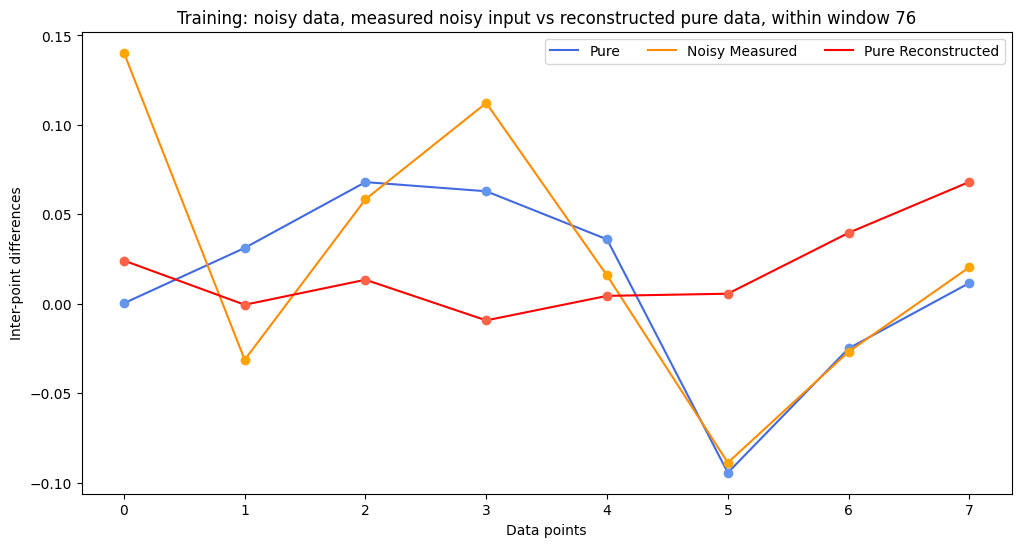

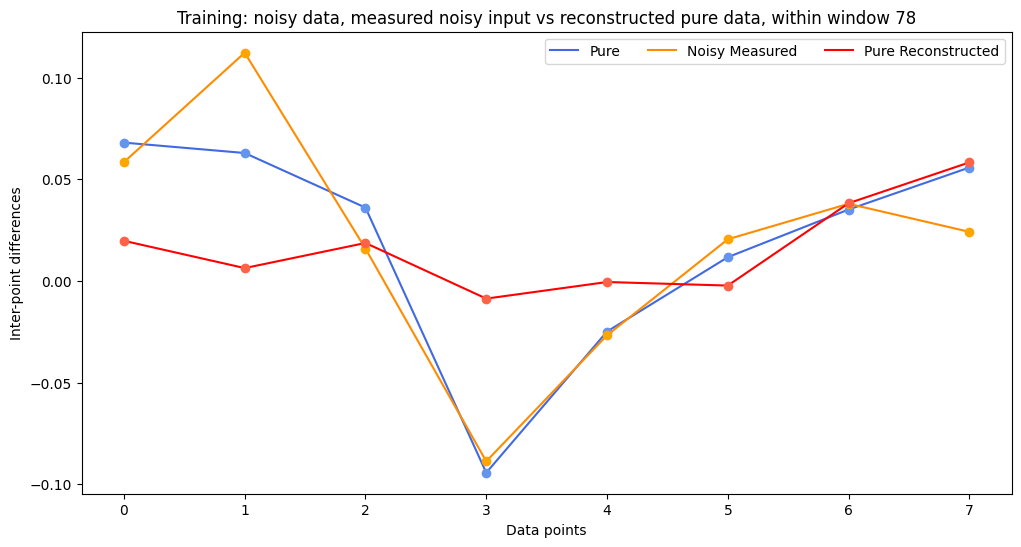

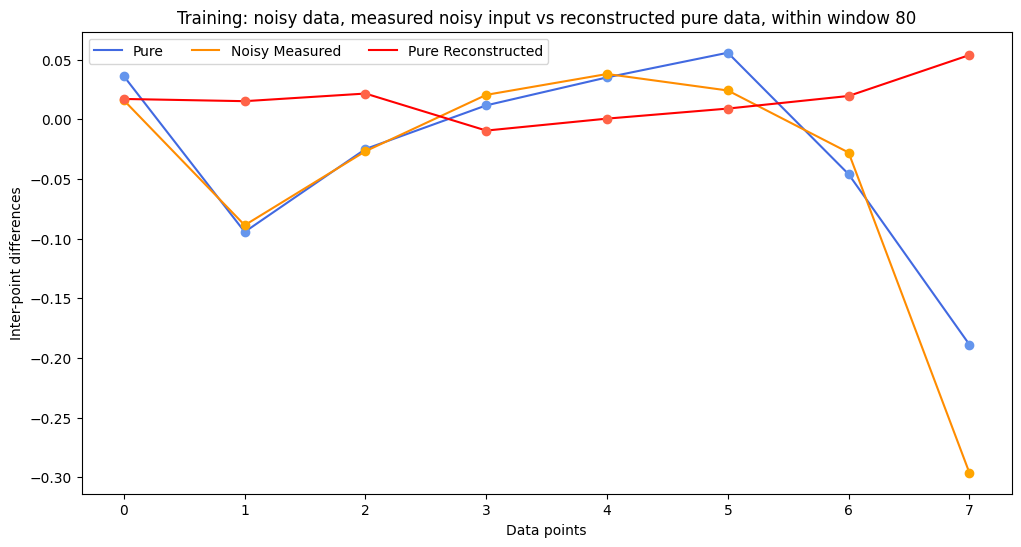

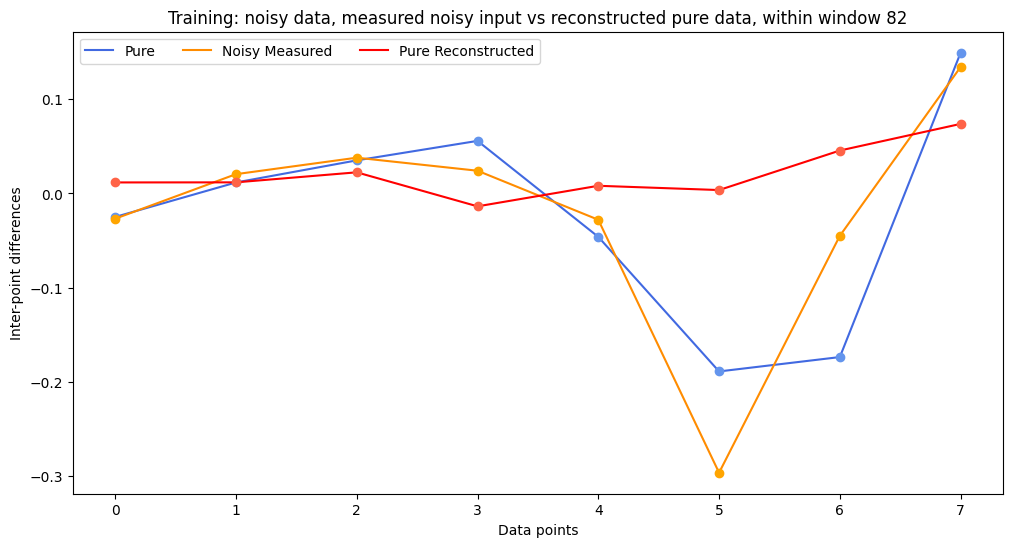

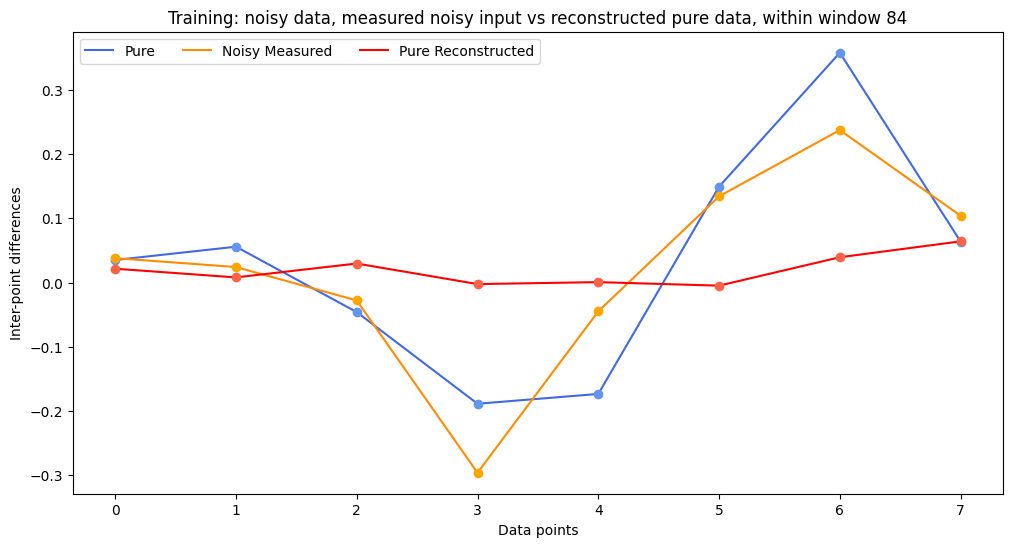

In [54]:
qae_plot_winds(in_org_train_set, in_meas_train_set, out_reconstr_train_set, plot_no=5, 
               title='Training: noisy data, measured noisy input vs reconstructed pure data',
               labels=['Pure', 'Noisy Measured', 'Pure Reconstructed'],
               save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_{epochs}/winds_pt_nt_pt')

#### Plotting results of analysis performed on validation data (not seen by the full-QAE)
The blue line shows pure data that was given on output during training.</br>
The red curve was reconstructed from the noisy data given on input (not shown here).<br/>
The yellow control curve measures the pure data, it follows the blue curve, the best it can.<br/>
The red curve should follow the blue pure data and its variance should not be much different from the yellow lines,<br/>
as it means it has learnt to recover pure data from noise given on input!<br/>
These charts show that the model can generalise away from data shown in training, subject to measurement error.

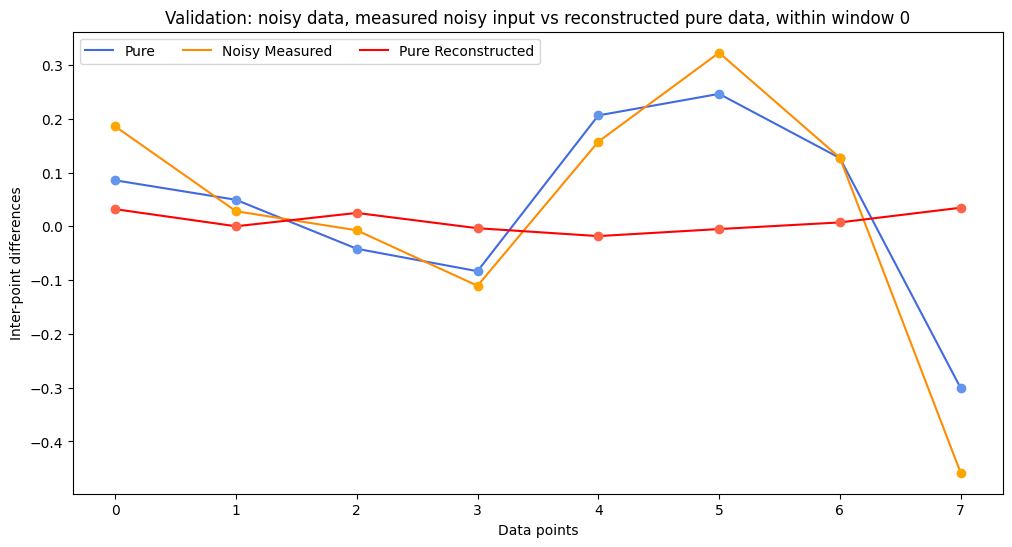

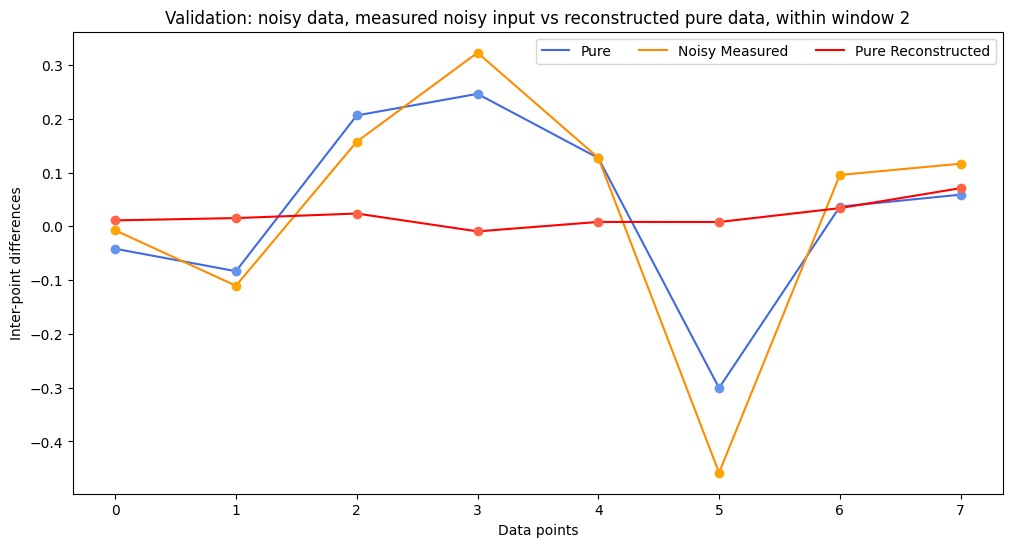

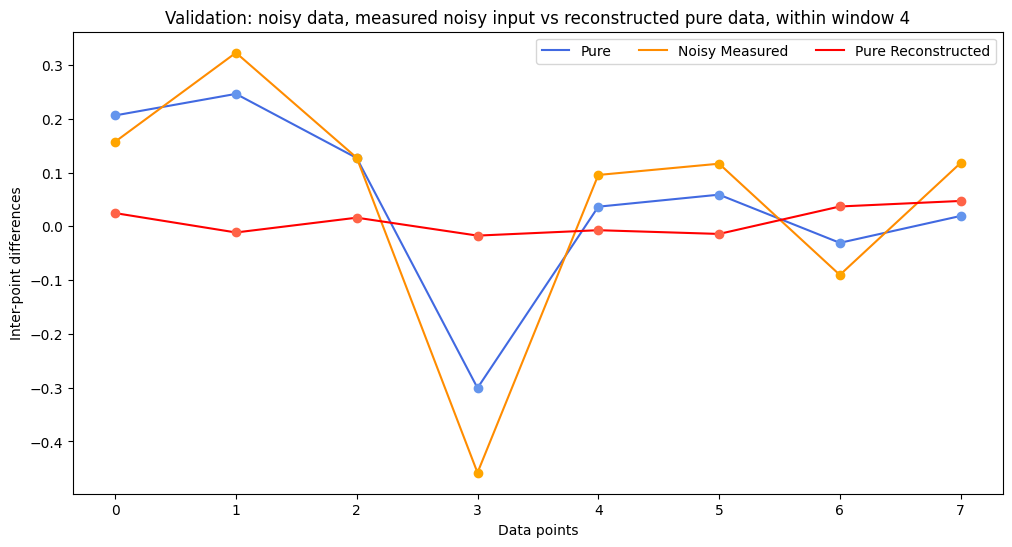

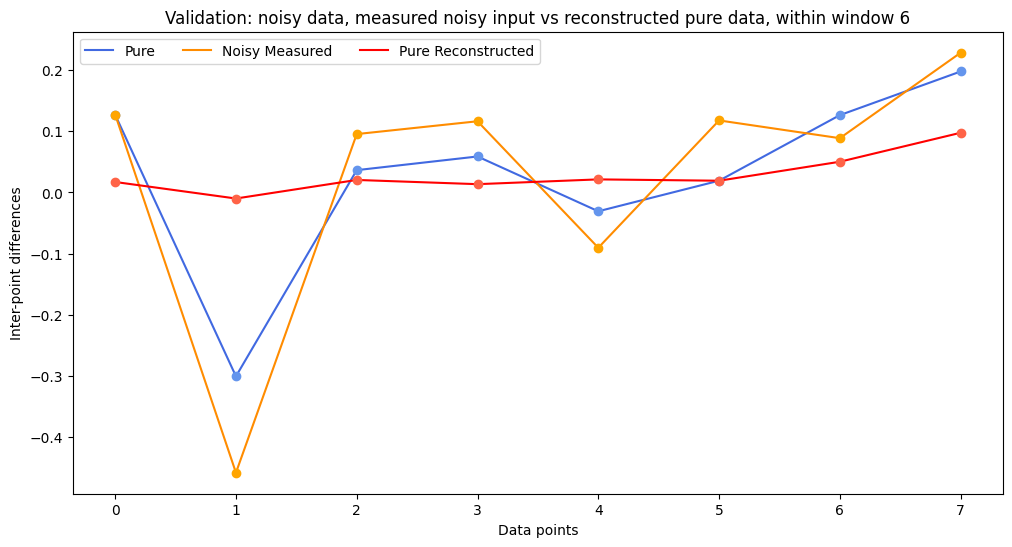

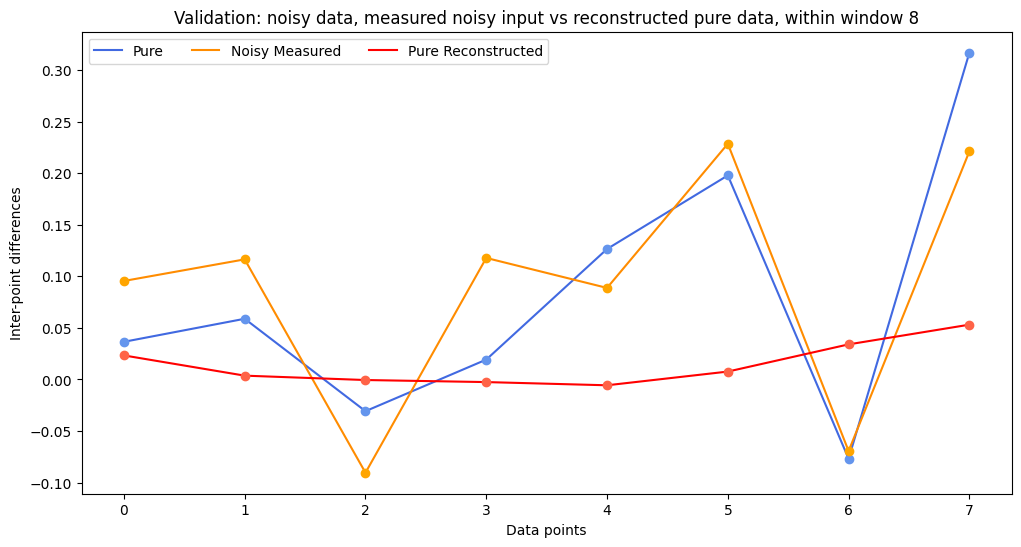

In [55]:
qae_plot_winds(in_org_valid_set, in_meas_valid_set, out_reconstr_valid_set, plot_no=5,
               title='Validation: noisy data, measured noisy input vs reconstructed pure data',
               labels=['Pure', 'Noisy Measured', 'Pure Reconstructed'],
               save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_{epochs}/winds_pv_nv_pv')

### Accuracy of results after manual removal of edge distortion in a series windows
Based on visual inspection of the QAE results, we can observe that the QAE results are distored at the edges.<br/>
So it is possibe to exclude a few data points from each data window, and hence improve the model accuracy.<br/><br/>
In the left column we have metrics comparing QAE inputs with the same but quantum measured inputs.<br/>
In the right column we have metrics comparing QAE inputs with its outputs - this is what we are intereted in.<br/>
The left column is for your reference to see the impact of measurement on the QAE precision.

In [56]:
### Present some statistics on the sample, after removing the edge distortion
trim_left = 2
trim_right = 2

mae_adj_inorg_train_incalc, mae_adj_inorg_train_outrec = accuracy_report(in_org_train_set, in_meas_train_set, out_reconstr_train_set, 
                title='Train. Acc.', trim_left=trim_left, trim_right=trim_right)
mae_adj_inorg_valid_incalc, mae_adj_inorg_valid_outrec = accuracy_report(in_org_valid_set, in_meas_valid_set, out_reconstr_valid_set, 
                title='Valid. Acc.', trim_left=trim_left, trim_right=trim_right)
print()


Train. Acc.	Pure vs Noisy	Pure vs Recovered

R2        	0.888      	-0.02     
RMS       	0.084      	0.254     
MAE       	0.066      	0.18      
MAPE      	1.295      	1.088     

Valid. Acc.	Pure vs Noisy	Pure vs Recovered

R2        	0.923      	-0.013    
RMS       	0.067      	0.243     
MAE       	0.056      	0.177     
MAPE      	1.123      	1.069     



### Saving the starting point and calculated results

In [57]:
print(f'Files to be saved (when True)\n')
print(f'Original training windows:     {train_inorg_fpath}')
print(f'Measured training windows:     {train_inmeas_fpath}')
print(f'Resulting training windows:    {train_outrec_fpath}\n')
print(f'Original validation windows:   {valid_inorg_fpath}')
print(f'Measured validation windows:   {valid_inmeas_fpath}')
print(f'Resulting validation windows:  {valid_outrec_fpath}\n')

Files to be saved (when True)

Original training windows:     beer_xtest/analysis/2step_xy_n200_w8_ws2_z0.03_zr1_reps2_aw1_sca_lat7_1000/winds_torg.json
Measured training windows:     beer_xtest/analysis/2step_xy_n200_w8_ws2_z0.03_zr1_reps2_aw1_sca_lat7_1000/winds_tinm.json
Resulting training windows:    beer_xtest/analysis/2step_xy_n200_w8_ws2_z0.03_zr1_reps2_aw1_sca_lat7_1000/winds_tout.json

Original validation windows:   beer_xtest/analysis/2step_xy_n200_w8_ws2_z0.03_zr1_reps2_aw1_sca_lat7_1000/winds_vorg.json
Measured validation windows:   beer_xtest/analysis/2step_xy_n200_w8_ws2_z0.03_zr1_reps2_aw1_sca_lat7_1000/winds_vinm.json
Resulting validation windows:  beer_xtest/analysis/2step_xy_n200_w8_ws2_z0.03_zr1_reps2_aw1_sca_lat7_1000/winds_vout.json



In [58]:
### Save all calculated data points
to_be_saved_results = True

if to_be_saved_results:
    write_json_file(f'{train_inorg_fpath}', in_org_train_set)
    write_json_file(f'{train_inmeas_fpath}', in_meas_train_set)
    write_json_file(f'{train_outrec_fpath}', out_reconstr_train_set)
    
    write_json_file(f'{valid_inorg_fpath}', in_org_valid_set)
    write_json_file(f'{valid_inmeas_fpath}', in_meas_valid_set)
    write_json_file(f'{valid_outrec_fpath}', out_reconstr_valid_set)
    
    print(f'Saved all calculated windows in: "{ANALYSIS_PATH}" folder')
else:
    print(f'Sample windows not saved') 

Saved all calculated windows in: "beer_xtest/analysis" folder


## Time series integration and plotting
The aim is to merge all windows produced in testing into a single sequence, stored as a dictionary. As depicted in the following figure, the integration procedure needs to average all overalapping windows values (white boxes), while considering the step between windows (which creates gaps between overlapping windows) and their edge trimming (which removes distorted values, indicated as gray boxes). 

<div>
    <!--img src="attachment:wind-integration.png" width="1000"-->
    <img src="../images/wind-integration.png" width="1000">
</div>

**Figure: Windows integration procedure**

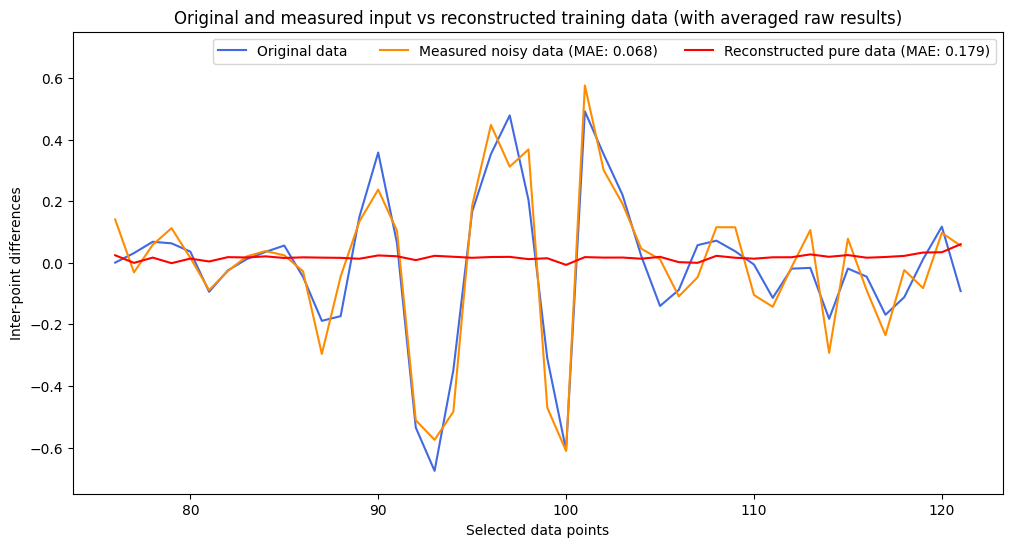

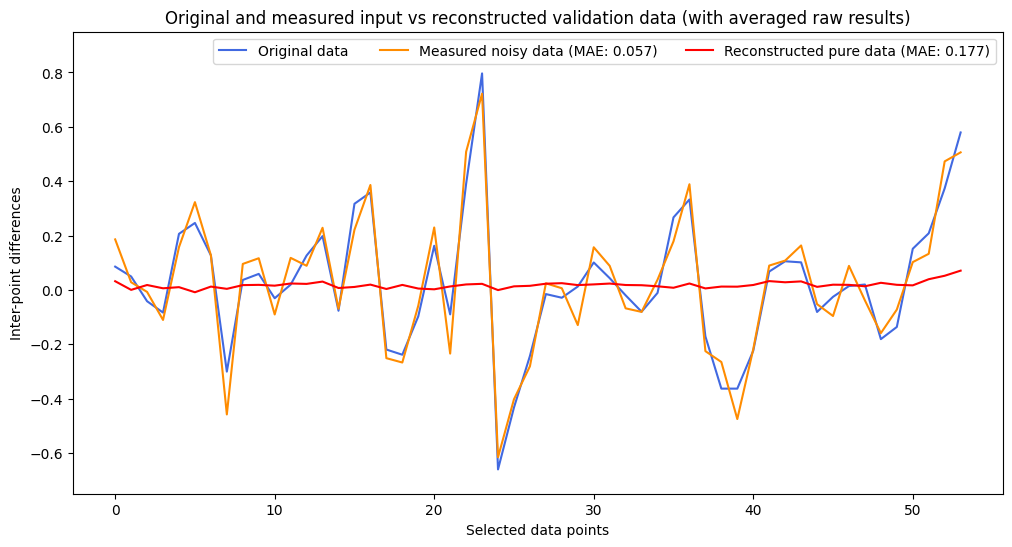

In [61]:
# Plot all raw results
in_org_train_seq, in_meas_train_seq, out_recons_train_seq = qae_winds_integ(in_org_train_set, in_meas_train_set, out_reconstr_train_set)
qae_seq_plot(in_org_train_seq, in_meas_train_seq, out_recons_train_seq, title=f'Original and measured input vs reconstructed training data (with averaged raw results)',
             labels=['Original data', 'Measured noisy data', 'Reconstructed pure data'],
             label_suffix=[f'', f'(MAE: {np.round(mae_inorg_train_incalc, 3)})', f'(MAE: {np.round(mae_inorg_train_outrec, 3)})'], ylim=(-0.75,0.75),
             save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_{epochs}/winds_inttra_org.eps')

in_org_valid_seq, in_meas_valid_seq, out_recons_valid_seq = qae_winds_integ(in_org_valid_set, in_meas_valid_set, out_reconstr_valid_set)
qae_seq_plot(in_org_valid_seq, in_meas_valid_seq, out_recons_valid_seq, title=f'Original and measured input vs reconstructed validation data (with averaged raw results)',
             labels=['Original data', 'Measured noisy data', 'Reconstructed pure data'],
             label_suffix=[f'', f'(MAE: {np.round(mae_inorg_valid_incalc, 3)})', f'(MAE: {np.round(mae_inorg_valid_outrec, 3)})'], ylim=(-0.75,0.95),
             save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_{epochs}/winds_intval_org.eps')

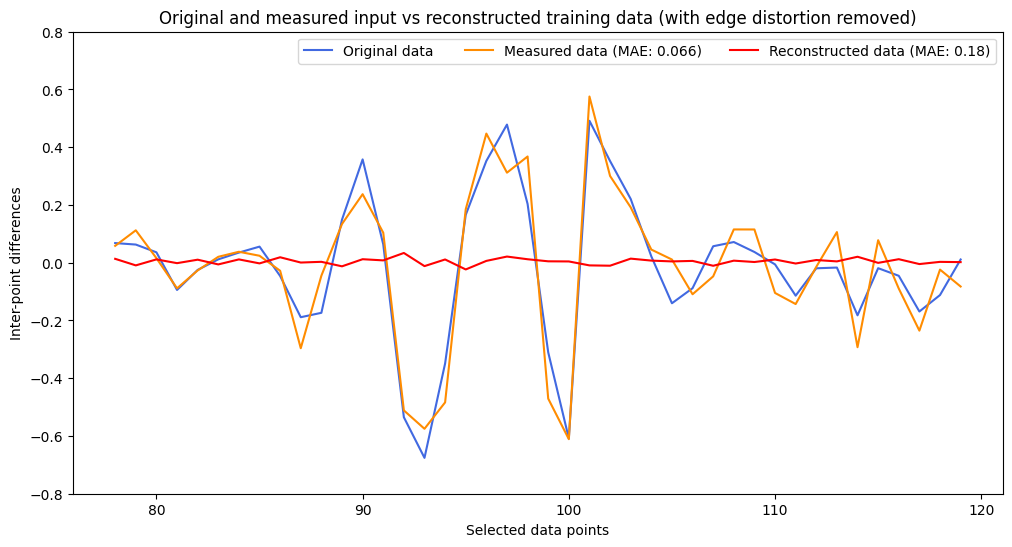

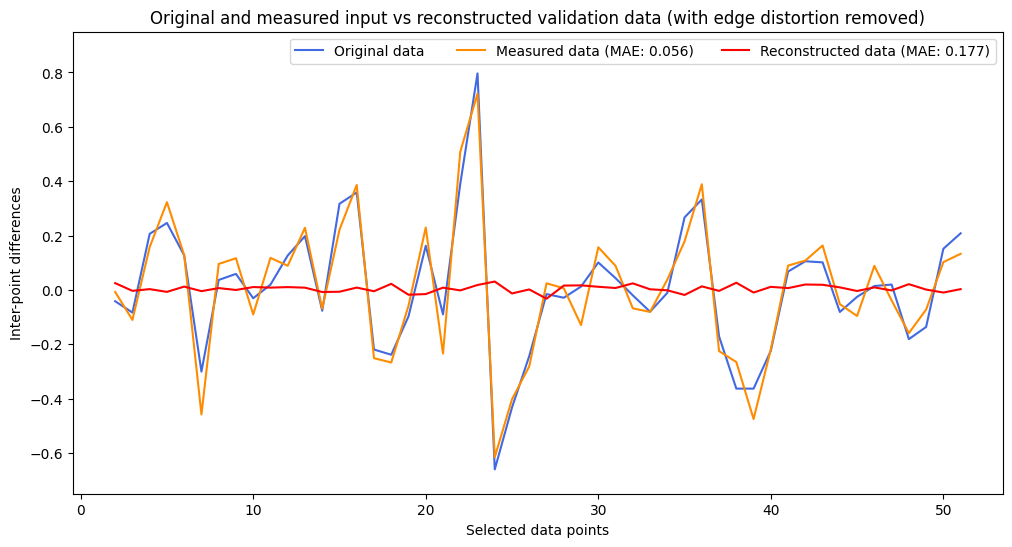

In [62]:
# Plot all results with distortion trimming
in_org_adj_train_seq, in_meas_adj_train_seq, out_recons_adj_train_seq = qae_winds_integ(in_org_train_set, in_meas_train_set, out_reconstr_train_set, trim_left, trim_right)
qae_seq_plot(in_org_adj_train_seq, in_meas_adj_train_seq, out_recons_adj_train_seq, title=f'Original and measured input vs reconstructed training data (with edge distortion removed)',
             label_suffix=[f'', f'(MAE: {np.round(mae_adj_inorg_train_incalc, 3)})', f'(MAE: {np.round(mae_adj_inorg_train_outrec, 3)})'], ylim=(-0.8, 0.8),
             save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_{epochs}/winds_inttra_adj.eps')

in_org_adj_valid_seq, in_meas_adj_valid_seq, out_recons_adj_valid_seq = qae_winds_integ(in_org_valid_set, in_meas_valid_set, out_reconstr_valid_set, trim_left, trim_right)
qae_seq_plot(in_org_adj_valid_seq, in_meas_adj_valid_seq, out_recons_adj_valid_seq, title=f'Original and measured input vs reconstructed validation data (with edge distortion removed)',
             label_suffix=[f'', f'(MAE: {np.round(mae_adj_inorg_valid_incalc, 3)})', f'(MAE: {np.round(mae_adj_inorg_valid_outrec, 3)})'], ylim=(-0.75, 0.95),
             save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_{epochs}/winds_intval_adj.eps')

## References

1. A wikipedia page on Autoencoder: https://en.wikipedia.org/wiki/Autoencoder

2. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. "Quantum autoencoders for efficient compression of quantum data." Quantum Science and Technology 2.4 (2017): 045001.

3. Swap Test Algorithm: https://en.wikipedia.org/wiki/Swap_test

4. Bravo-Prieto, Carlos, "Quantum autoencoders with enhanced data encoding." Machine Learning: Science and Technology, 2, May 2021

# Software in use

In [62]:
!pip list | grep -E 'qiskit|torch'

qiskit                    0.46.0
qiskit-aer                0.13.3
qiskit-algorithms         0.2.2
qiskit-machine-learning   0.7.1
qiskit-terra              0.46.0
torch                     2.3.0+cpu
torchaudio                2.3.0+cpu
torchvision               0.18.0+cpu
